### compare pangenome of *S.cerevisiae* and 7 closed yeasts pangenome to characterize the evolution of core genome of yeast
- pangenome struture comparison: pangenome size, core genome size
- core genome fuctional comparison
- core genome gene copy number variance comparison

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy import stats

# set work dir
os.chdir(r'D:\code\github\Unified_Yeast_GEMs_Database')


#### 1.pangenome structure comparison

In [3]:
# load geneMatrix
sce1800_geneMatrix=pd.read_csv(r"data\geneMatrix\pan1800_v2_blastp_50_70_geneMatrix.csv",index_col=0)
yeasts_geneMatrix=pd.read_csv(r"data\geneMatrix\yeasts_blastp_50_70_cnvMatrix.csv",index_col=0)

sce1800_core99=sce1800_geneMatrix[sce1800_geneMatrix.sum(axis=1)>=sce1800_geneMatrix.shape[1]*0.99].index.tolist()
yeasts_coreList=yeasts_geneMatrix[yeasts_geneMatrix.sum(axis=1)==yeasts_geneMatrix.shape[1]].index.tolist()

col=["mean proteome size","std","pan-genome size","core-genome size"]
sce1800_info=[sce1800_geneMatrix.sum().describe()['mean'],sce1800_geneMatrix.sum().describe()['std'],sce1800_geneMatrix.shape[0],len(sce1800_core99)]
yeasts_info=[yeasts_geneMatrix.sum().describe()['mean'],yeasts_geneMatrix.sum().describe()['std'],yeasts_geneMatrix.shape[0],len(yeasts_coreList)]


df_sce1800_vs_yeasts=pd.DataFrame([sce1800_info,yeasts_info],columns=col,index=['S.cerevisiae 1800','yeasts'])
df_sce1800_vs_yeasts


,mean proteome size,std,pan-genome size,core-genome size
S.cerevisiae 1800,5982.58218,68.776684,7514,4766
yeasts,5159.75000,659.259921,9232,2974


- a bar plot for this dataframe finished in PPT

#### 2.coregenome functional comparison

In [8]:
# load functioanal annotation
pan1800_functional_info=pd.read_excel(r"data/genome/pan1800_functional_annotations.xlsx",skiprows=2,index_col=0)
yeasts_functional_info=pd.read_excel(r"data/genome/yeasts_pangenome_functional_annotations.xlsx",skiprows=2,index_col=0)

pan1800_core_functional_info=pan1800_functional_info[pan1800_functional_info.index.isin(sce1800_core99)]
yeasts_core_functional_info=yeasts_functional_info[yeasts_functional_info.index.isin(yeasts_coreList)]

In [4]:
# check sce1800 pangenome and yeasts pangenome common core genes
# common_core=list(set(sce1800_core99).intersection(set(yeasts7_coreList)))
# common_core_functional_info=pan1800_functional_info[pan1800_functional_info.index.isin(common_core)]

In [9]:
def get_cog_counts(df_annotation,df_cog):
    '''get COG number counts'''
    df_annotation = df_annotation.dropna(subset=["COG_category"])
    cog_list = df_cog.index.tolist()
    cog_counts=pd.Series(index=cog_list)
    for i in cog_list:
        count = len(df_annotation[df_annotation["COG_category"].str.contains(i)])
        cog_counts[i] = count
    return cog_counts

# load COG category,set columns as "COG","category"
df_cog=pd.read_csv("data/cog_cotegory",index_col=0,sep="\t",header=None)
df_cog.columns=["color","description"]

#check 7 yeasts core genome , 1800 sce core genome and common core genome COG category distribution
yeasts_cog_counts=get_cog_counts(yeasts_core_functional_info,df_cog)
sce1800_cog_counts=get_cog_counts(pan1800_core_functional_info,df_cog)
# common_core_cog_counts=get_cog_counts(common_core_functional_info,df_cog)
df_cog_counts=pd.DataFrame(columns=["yeasts","S.cerevisiae 1800"])
df_cog_counts["yeasts"]=yeasts_cog_counts
df_cog_counts["S.cerevisiae 1800"]=sce1800_cog_counts
# df_cog_counts["common core"]=common_core_cog_counts
df_cog_counts=df_cog_counts.fillna(0)
df_cog_counts=df_cog_counts.astype(int)
# remove cog that all counts are less than 5
df_cog_counts=df_cog_counts[(df_cog_counts>5).any(axis=1)]
df_cog_counts=df_cog_counts.sort_values(by="yeasts",ascending=False)
cog_list=df_cog_counts.index.tolist()


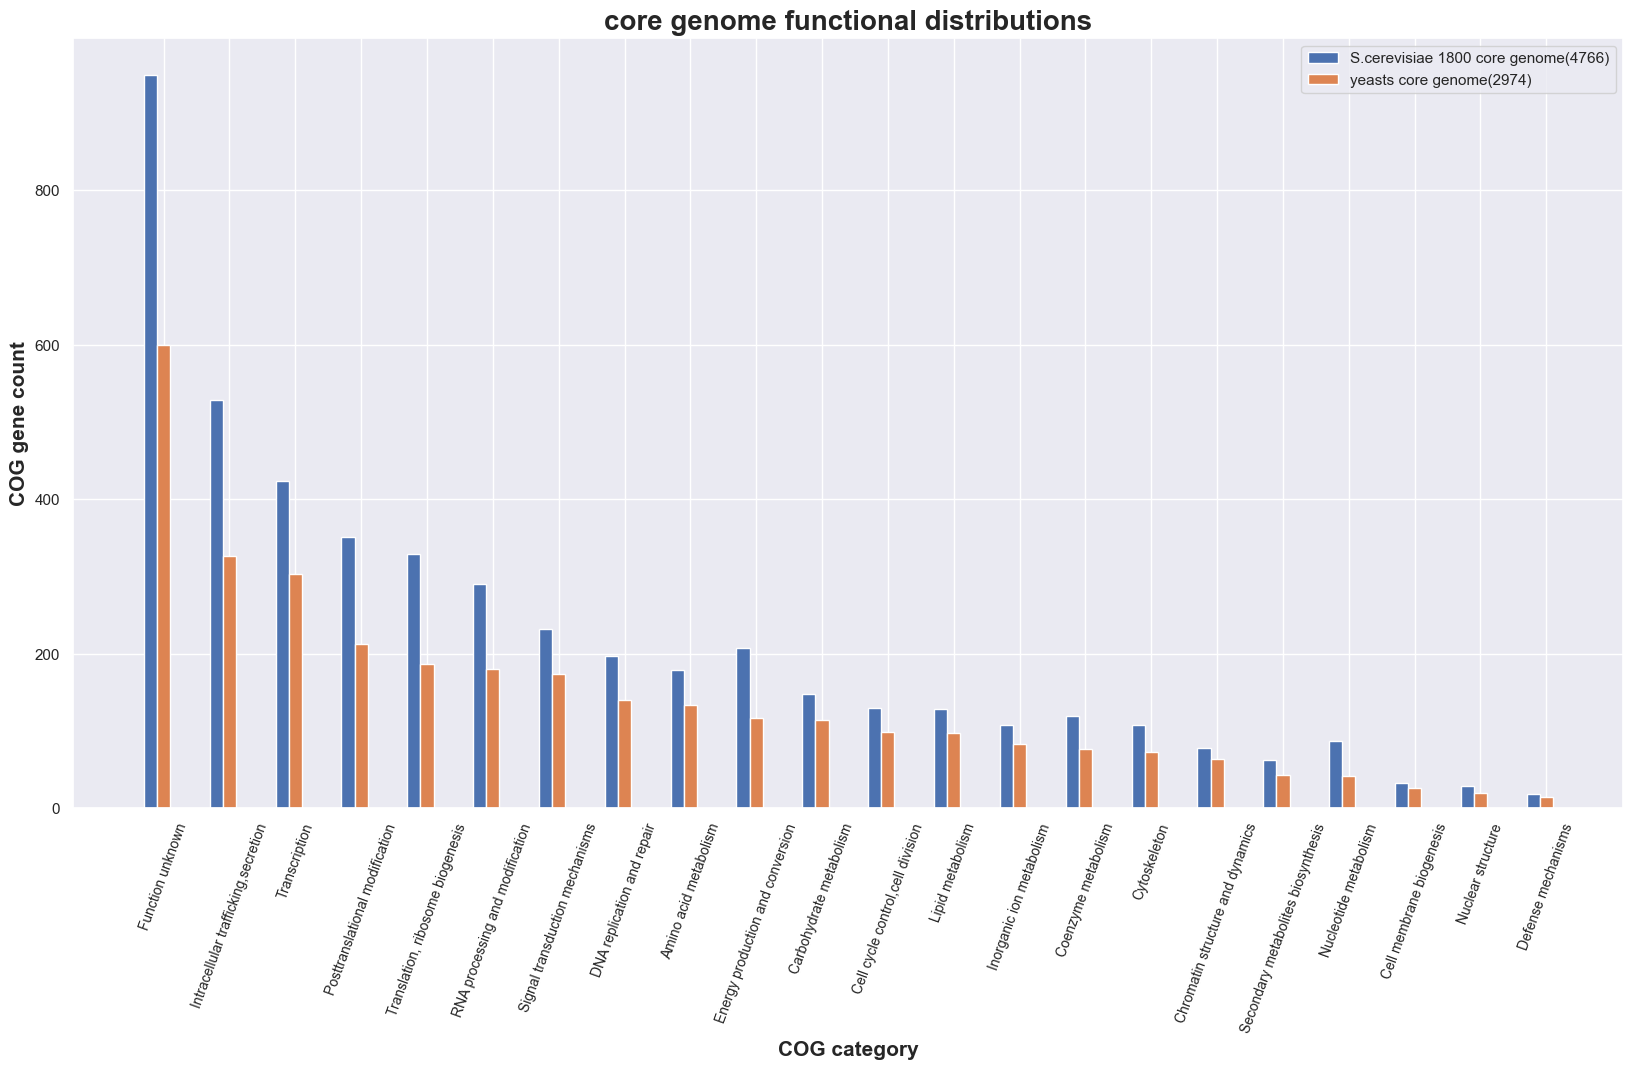

In [11]:
# plot grouped barplot to compare COG gene count in each COG category for 3 pangenome
plt.figure(figsize=(20,10))
sns.set()
bar_width = 0.2
index=np.arange(len(cog_list))
plt.bar(index,df_cog_counts["S.cerevisiae 1800"],bar_width,label="S.cerevisiae 1800 core genome(%s)"%len(sce1800_core99))
plt.bar(index+bar_width,df_cog_counts["yeasts"],bar_width,label="yeasts core genome(%s)"%len(yeasts_coreList))
# plt.bar(index+bar_width*2,df_cog_counts["common core"],bar_width,label="common core genes(%s)"%len(common_core))
plt.xlabel('COG category',fontsize=15,fontweight='bold')
plt.ylabel('COG gene count',fontsize=15,fontweight='bold')
plt.title('core genome functional distributions',fontsize=20,fontweight='bold')
cog_description=df_cog.loc[cog_list,"description"].tolist()
plt.xticks(index+bar_width, cog_description,rotation=70,fontsize=10)
plt.legend()
plt.show()



In [12]:
# calculate the common core count divided by S.cerevisiae 1800 core genome count
df_cog_counts["yeasts core/sce core"]=df_cog_counts["yeasts"]/df_cog_counts["S.cerevisiae 1800"]
df_cog_counts['cog description']=df_cog.loc[df_cog_counts.index,"description"]
df_cog_counts=df_cog_counts.sort_values(by="yeasts core/sce core",ascending=False)
df_cog_counts

# save df_cog_counts
df_cog_counts.to_csv(r"code/4.core_genome_analysis/compare_with_closed_yeasts/output/yeasts_vs_sce1800_core_cog_counts.csv")

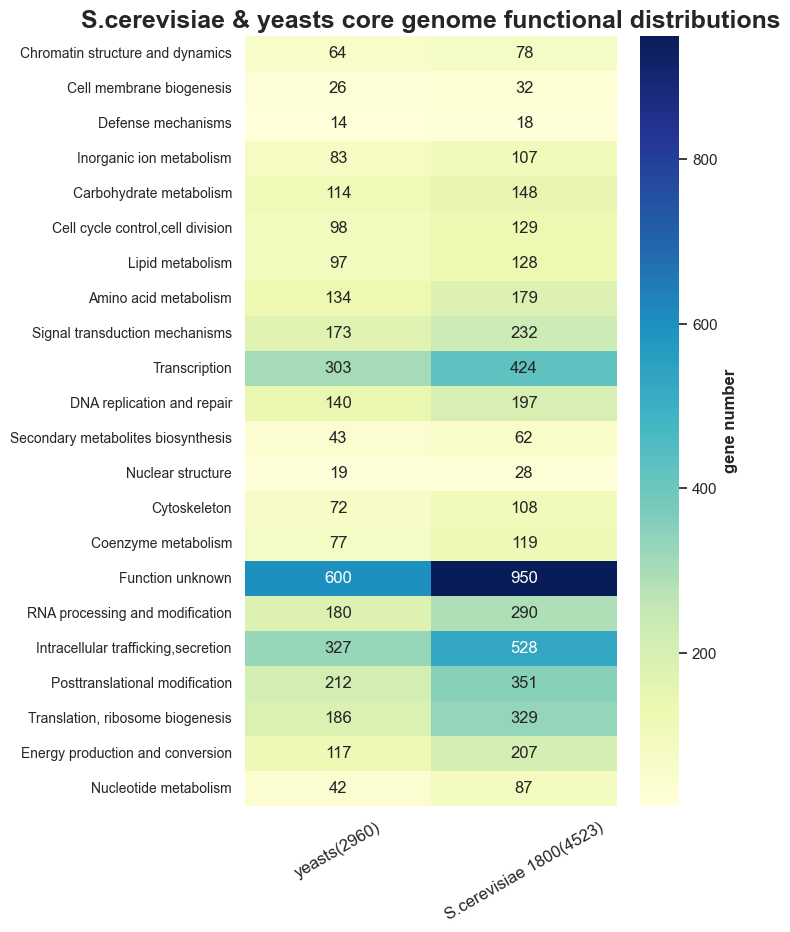

In [13]:
# plot heatmap to compare COG gene count in each COG category for 3 pangenome
plt.figure(figsize=(6,10))
sns.set()
plt.title('S.cerevisiae & yeasts core genome functional distributions',fontsize=18,fontweight='bold')
# sns.heatmap(df_cog_ratios,annot=True,fmt=".4f",cmap="YlGnBu")
sns.heatmap(df_cog_counts.iloc[:,:2],annot=True,fmt="d",cmap="YlGnBu")
# set colorbar title
cbar = plt.gca().collections[0].colorbar
cbar.set_label('gene number',fontsize=12,fontweight='bold')
# rest xticklabels
xlabels=["yeasts(%s)"%len(yeasts_core_functional_info),"S.cerevisiae 1800(%s)"%len(pan1800_core_functional_info)]
plt.xticks(np.arange(2)+0.5, xlabels,rotation=30,fontsize=12)
plt.yticks(np.arange(len(cog_list))+0.5, df_cog_counts['cog description'],rotation=0,fontsize=10)
plt.show()

- comclusion:<br>
1. Metabolic genes in different pathway shows universal higher conservation comparing to other genes involved in other cell activities
2. Chromatin structure and dynamics function is most conserved.
3. Genes involved in RNA/protein modification, protein secretion and so on show more variable in core genome.
 

#### 3.Copy number differnece sce core genome and yeast 7 core genome

In [15]:
# load gene copy number variance data
sce1800_cnvMatrix=pd.read_csv(r"data\geneMatrix\pan1800_v2_blastp_50_70_cnvMatrix.csv",index_col=0)
yeasts_cnvMatrix=pd.read_csv(r"data\geneMatrix\yeasts_blastp_50_70_cnvMatrix.csv",index_col=0)

yeasts_coreList=list(set(yeasts_coreList).intersection(set(sce1800_core99)))
sce1800_core_cnvMatrix=sce1800_cnvMatrix[sce1800_cnvMatrix.index.isin(sce1800_core99)]
yeasts_core_cnvMatrix=yeasts_cnvMatrix[yeasts_cnvMatrix.index.isin(yeasts_coreList)]

In [16]:
def evaluate_cnvMatrix(cnvMatrix):
    '''calculate the mean copy number, standard deviation, coefficient of variation and dispersion for each gene without 0 value.
    As for dispersion, it is defined as average absolute deviation from the mean.
    '''
    df_cnv_info=pd.DataFrame(columns=["mean","std","cv","dispersion"])
    cnvMatrix=cnvMatrix.astype(float)
    df_cnv_info["mean"]=cnvMatrix[cnvMatrix>0].mean(axis=1)
    df_cnv_info["std"]=cnvMatrix[cnvMatrix>0].std(axis=1)
    df_cnv_info["cv"]=df_cnv_info["std"]/df_cnv_info["mean"]
    df_cnv_info["dispersion"]=cnvMatrix[cnvMatrix>0].apply(lambda x:np.abs(x-x.mean()),axis=1).mean(axis=1)

    # fill nan as the mean of each column
    df_cnv_info=df_cnv_info.fillna(df_cnv_info.mean())

    return df_cnv_info


In [17]:
# evaluate the cnvMatrix of S.cerevisiae and  yeasts pan-genome
df_sce_cnv_info=evaluate_cnvMatrix(sce1800_cnvMatrix)
df_yeasts_cnv_info=evaluate_cnvMatrix(yeasts_cnvMatrix)


# get core genome cnv info
sce1800_core_cnv_info=df_sce_cnv_info[df_sce_cnv_info.index.isin(sce1800_core99)]
yeasts_core_cnv_info=df_yeasts_cnv_info[df_yeasts_cnv_info.index.isin(yeasts_coreList)]

scecore_non_yeastcore_cnv_info=sce1800_core_cnv_info[~sce1800_core_cnv_info.index.isin(yeasts_coreList)]
sce_yeastcore_cnv_info=sce1800_core_cnv_info[sce1800_core_cnv_info.index.isin(yeasts_coreList)]
sceaccessory_cnv_info=df_sce_cnv_info[~df_sce_cnv_info.index.isin(sce1800_core99)]

print('scecore non yeastcore genes: %s'%len(scecore_non_yeastcore_cnv_info))
print('yeast core genes: %s'%len(yeasts_core_cnv_info))

df_sce_cnv_info

scecore non yeastcore genes: 2026
yeast core genes: 2740


,mean,std,cv,dispersion
YAL001C,1.004986,0.084743,0.084322,0.009934
YAL002W,1.005003,0.084884,0.084461,0.009967
YAL003W,1.004459,0.081687,0.081325,0.008889
YAL004W,1.185621,0.389055,0.328144,0.302332
YAL008W,1.015573,0.155700,0.153313,0.030799
...,...,...,...,...
YOR108W,1.011316,0.143979,0.142368,0.022484
YOL086C,1.037383,0.255400,0.246197,0.072932
YBR145W,1.048253,0.304245,0.290240,0.093669
YMR303C,1.012346,0.130024,0.128439,0.024445


In [18]:
# add type to df_sce_cnv_info as yeast_core, sce_core, accessory
df_sce_cnv_info['type']=df_sce_cnv_info.index.map(lambda x:'yeast_core' if x in yeasts_coreList else 'sce_core' if x in sce1800_core99 else 'accessory')
df_sce_cnv_info['type'].value_counts()
# save result
df_sce_cnv_info.to_csv(r"code/4.core_genome_analysis/compare_with_closed_yeasts/output/sce1800_cnv_info.csv")
df_sce_cnv_info['type'].value_counts()

type
accessory     2748
yeast_core    2740
sce_core      2026
Name: count, dtype: int64

mean copy number of yeast core genome: 1.022744621566525
mean copy number of S.cerevisiae core genome: 1.0849964036445219
mean copy number of S.cerevisiae accessory genome: 1.0923273036828776
p-value of yeast core genome to S.cerevisiae core genome: 5.1662952210498167e-23
p-value of S.cerevisiae accessory genome to S.cerevisiae core genome: 0.5371070591715279


C:\Users\wangh\AppData\Local\Temp\ipykernel_41032\235817215.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sce_yeastcore_cnv_info["mean"],shade=True,label="Yeast core")
C:\Users\wangh\AppData\Local\Temp\ipykernel_41032\235817215.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scecore_non_yeastcore_cnv_info["mean"],shade=True,label="Sce core")
C:\Users\wangh\AppData\Local\Temp\ipykernel_41032\235817215.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sceaccessory_cnv_info["mean"],shade=True,label="Accessory")


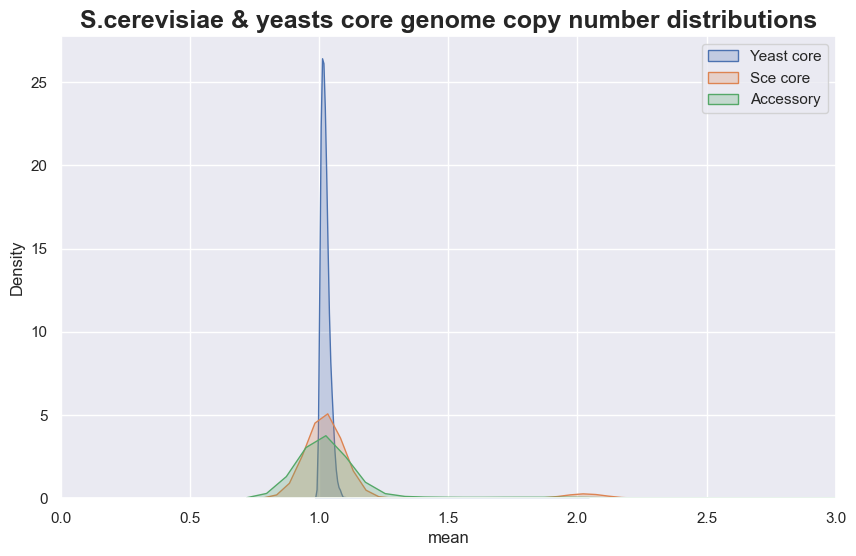

In [20]:
#calculate the mean copy number of 3 gene sets, and calculate the p-value to S.cerevisiae core genome
print("mean copy number of yeast core genome: %s"%sce_yeastcore_cnv_info["mean"].mean())
print("mean copy number of S.cerevisiae core genome: %s"%scecore_non_yeastcore_cnv_info["mean"].mean())
print("mean copy number of S.cerevisiae accessory genome: %s"%sceaccessory_cnv_info["mean"].mean())
print("p-value of yeast core genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sce_yeastcore_cnv_info["mean"],scecore_non_yeastcore_cnv_info["mean"])[1])
print("p-value of S.cerevisiae accessory genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sceaccessory_cnv_info["mean"],scecore_non_yeastcore_cnv_info["mean"])[1])

# plot kdensity plot to compare core genome copy number distribution
plt.figure(figsize=(10,6))
sns.set()
plt.title('S.cerevisiae & yeasts core genome copy number distributions',fontsize=18,fontweight='bold')
sns.kdeplot(sce_yeastcore_cnv_info["mean"],shade=True,label="Yeast core")
sns.kdeplot(scecore_non_yeastcore_cnv_info["mean"],shade=True,label="Sce core")
sns.kdeplot(sceaccessory_cnv_info["mean"],shade=True,label="Accessory")

plt.xlim(0,3)
plt.legend()
plt.show()

mean copy number of yeast core genome: 1.022744621566525
mean copy number of S.cerevisiae core genome: 1.0849964036445219
mean copy number of S.cerevisiae accessory genome: 1.0923273036828776
p-value of yeast core genome to S.cerevisiae core genome: 5.1662952210498167e-23
p-value of S.cerevisiae accessory genome to S.cerevisiae core genome: 0.5371070591715279


C:\Users\wangh\AppData\Local\Temp\ipykernel_41032\2332480670.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df,x='type',y='mean copy number',palette="Set3")


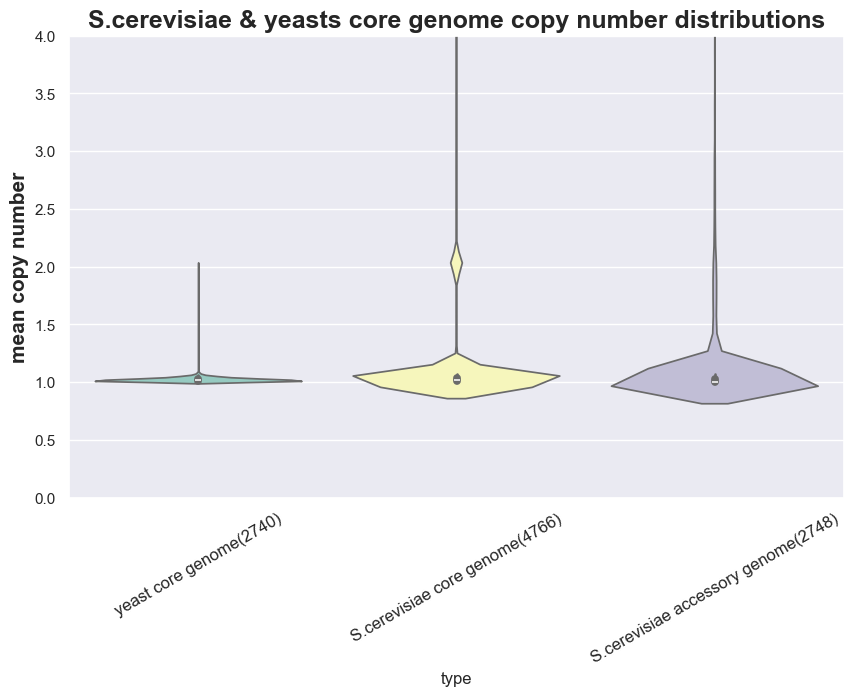

In [41]:
#calculate the mean copy number of 3 gene sets, and calculate the p-value to S.cerevisiae core genome
print("mean copy number of yeast core genome: %s"%sce_yeastcore_cnv_info["mean"].mean())
print("mean copy number of S.cerevisiae core genome: %s"%scecore_non_yeastcore_cnv_info["mean"].mean())
print("mean copy number of S.cerevisiae accessory genome: %s"%sceaccessory_cnv_info["mean"].mean())
print("p-value of yeast core genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sce_yeastcore_cnv_info["mean"],scecore_non_yeastcore_cnv_info["mean"])[1])
print("p-value of S.cerevisiae accessory genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sceaccessory_cnv_info["mean"],scecore_non_yeastcore_cnv_info["mean"])[1])

# plot violin plot to compare the mean gene copy number of 3 gene sets
plt.figure(figsize=(10,6))
plt.title('S.cerevisiae & yeasts core genome copy number distributions',fontsize=18,fontweight='bold')
df=pd.DataFrame(columns=["mean copy number","type"])
df["mean copy number"]=sce_yeastcore_cnv_info["mean"].tolist()+scecore_non_yeastcore_cnv_info["mean"].tolist()+sceaccessory_cnv_info["mean"].tolist()
df["type"]=["yeast core"]*len(sce_yeastcore_cnv_info)+["S.cerevisiae core"]*len(scecore_non_yeastcore_cnv_info)+["S.cerevisiae accessory"]*len(sceaccessory_cnv_info)
sns.violinplot(data=df,x='type',y='mean copy number',palette="Set3")
plt.xticks(np.arange(3), ["yeast core genome(%s)"%len(yeasts_core_cnv_info),"S.cerevisiae core genome(%s)"%len(sce1800_core_cnv_info),"S.cerevisiae accessory genome(%s)"%len(sceaccessory_cnv_info)],rotation=30,fontsize=12)
plt.ylabel("mean copy number",fontsize=15,fontweight='bold')
plt.ylim(0,4)
plt.show()

In [27]:
scecore_non_yeastcore_cnv_info["mean"].describe()
sceaccessory_cnv_info["mean"].describe()

count    2748.000000
mean        1.092327
std         0.454977
min         1.000000
25%         1.000000
50%         1.000753
75%         1.028094
max        15.666998
Name: mean, dtype: float64

mean cv of yeast core genome: 0.17373101369511895
mean cv of S.cerevisiae core genome: 0.16453529437624811
mean cv of S.cerevisiae accessory genome: 0.13247206113615698
p-value of yeast core genome to S.cerevisiae core genome: 2.3664297595569992e-05
p-value of S.cerevisiae accessory genome to S.cerevisiae core genome: 1.222223561683705e-15


C:\Users\wangh\AppData\Local\Temp\ipykernel_41032\2187204965.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df,x='type',y='cv',palette="Set3")


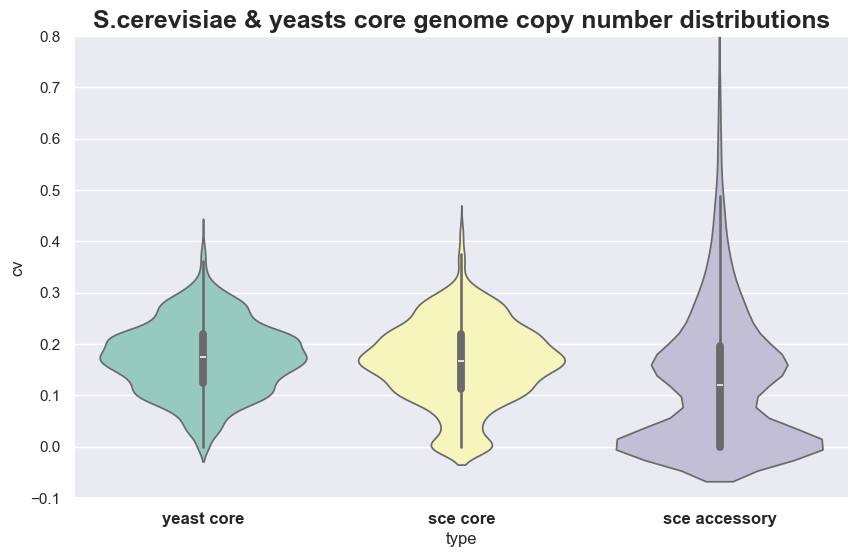

In [42]:
#calculate the mean cv of 3 gene sets, and calculate the p-value 
print("mean cv of yeast core genome: %s"%sce_yeastcore_cnv_info["cv"].mean())
print("mean cv of S.cerevisiae core genome: %s"%scecore_non_yeastcore_cnv_info["cv"].mean())
print("mean cv of S.cerevisiae accessory genome: %s"%sceaccessory_cnv_info["cv"].mean())
print("p-value of yeast core genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sce_yeastcore_cnv_info["cv"],scecore_non_yeastcore_cnv_info["cv"])[1])
print("p-value of S.cerevisiae accessory genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sceaccessory_cnv_info["cv"],scecore_non_yeastcore_cnv_info["cv"])[1])

# plot violin plot to compare the coefficient of variation of gene copy number of 3 gene sets
plt.figure(figsize=(10,6))
plt.title('S.cerevisiae & yeasts core genome copy number distributions',fontsize=18,fontweight='bold')
df=pd.DataFrame(columns=["cv","type"])
df["cv"]=sce_yeastcore_cnv_info["cv"].tolist()+scecore_non_yeastcore_cnv_info["cv"].tolist()+sceaccessory_cnv_info["cv"].tolist()
df["type"]=["yeast core"]*len(sce_yeastcore_cnv_info)+["S.cerevisiae core"]*len(scecore_non_yeastcore_cnv_info)+["S.cerevisiae accessory"]*len(sceaccessory_cnv_info)
# sns.violinplot(data=[sce_yeastcore_cnv_info["cv"],scecore_non_yeastcore_cnv_info["cv"],sceaccessory_cnv_info["cv"]],palette="Set3",cut=0)
sns.violinplot(data=df,x='type',y='cv',palette="Set3")
# set xticklabels
plt.xticks(np.arange(3), ['yeast core','sce core','sce accessory'],fontsize=12,fontweight='bold')
# set ylim
plt.ylim(-0.1,0.8)
plt.show()

mean copy number of yeast core genome: 1.0404657062844318
mean copy number of S.cerevisiae core genome: 1.0618644842631053
p-value of yeast core genome to S.cerevisiae core genome: 0.0007760249762759553


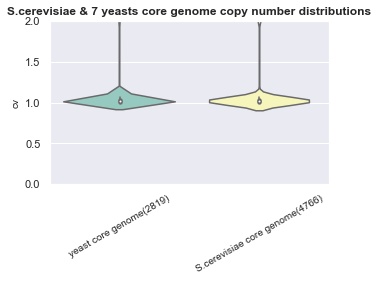

In [113]:
# calculate the mean value,and p value
print("mean copy number of yeast core genome: %s"%sce_yeastcore_cnv_info["mean"].mean())
print("mean copy number of S.cerevisiae core genome: %s"%scecore_non_yeastcore_cnv_info["mean"].mean())
print(r"p-value of yeast core genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sce_yeastcore_cnv_info["mean"],scecore_non_yeastcore_cnv_info["mean"])[1])

# plot kdensity plot to compare core genome copy number distribution
plt.figure(figsize=(5,3))
sns.set()
plt.title('S.cerevisiae & yeasts core genome copy number distributions',fontsize=12,fontweight='bold')
sns.violinplot(data=[sce_yeastcore_cnv_info["mean"],scecore_non_yeastcore_cnv_info["mean"]],palette="Set3")
plt.xticks([0,1],["yeast core genome(%s)"%len(yeasts_core_cnv_info),"S.cerevisiae core genome(%s)"%len(sce1800_core_cnv_info)],rotation=30,fontsize=10)
plt.ylabel("cv",fontsize=10)
plt.ylim(0,2)
plt.show()

mean copy number of yeast core genome: 0.1734481651325328
mean copy number of S.cerevisiae core genome: 0.16457170334992025
p-value of yeast core genome to S.cerevisiae core genome: 4.970138589834275e-05


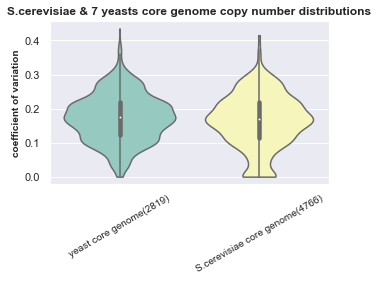

In [114]:
# calculate the mean value,and p value
print("mean copy number of yeast core genome: %s"%sce_yeastcore_cnv_info["cv"].mean())
print("mean copy number of S.cerevisiae core genome: %s"%scecore_non_yeastcore_cnv_info["cv"].mean())
print(r"p-value of yeast core genome to S.cerevisiae core genome: %s"%stats.ttest_ind(sce_yeastcore_cnv_info["cv"],scecore_non_yeastcore_cnv_info["cv"])[1])

# plot violin plot to compare core genome coeffcient of variation of gene copy number
plt.figure(figsize=(5,3))
sns.set()
plt.title('S.cerevisiae & yeasts core genome copy number distributions',fontsize=12,fontweight='bold')
sns.violinplot(data=[sce_yeastcore_cnv_info["cv"],scecore_non_yeastcore_cnv_info["cv"]],palette="Set3",cut=0)
plt.xticks([0,1],["yeast core genome(%s)"%len(yeasts_core_cnv_info),"S.cerevisiae core genome(%s)"%len(sce1800_core_cnv_info)],rotation=30,fontsize=10)
plt.ylabel("coefficient of variation",fontsize=10,fontweight='bold')
plt.show()

- conclusion:
    1. yeast 和 S.cerevisiae 的核心基因的平均拷贝数都显示出更加的一致，相比于accessory genome. yeasts中差别不显著可能是由菌株数量过少造成的。
    2. S.cerevisiae core genome 拷贝数变异程度显著高于accessory genome


#### 4. compare CNV between yeasts core genome and sce1800 core genome

p value of 7 yeasts core genome and S.cerevisiae core genome non-7yeasts mean copy number distribution is 0.043576032287819026


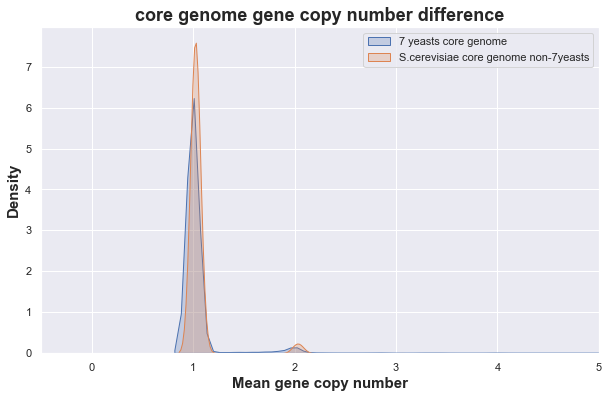

In [166]:
# compare gene copy number difference between sce core genome and 7 yeasts core genome
plt.figure(figsize=(10,6))
sns.set()
plt.title('core genome gene copy number difference',fontsize=18,fontweight='bold')
yeasts_core_mean_cnlist=sce1800_core_cnv_info[sce1800_core_cnv_info.index.isin(yeasts_coreList)]["mean"]
sce_core_nonyeasts_mean_cnlist=sce1800_core_cnv_info[~sce1800_core_cnv_info.index.isin(yeasts_coreList)]["mean"]
sns.kdeplot(yeasts_core_mean_cnlist,label="yeasts core genome",shade=True)
sns.kdeplot(sce_core_nonyeasts_mean_cnlist,label="S.cerevisiae core genome non-7yeasts",shade=True)
# check weather the core genome and accessory genome have the same distribution
t,p=stats.ttest_ind(yeasts_core_mean_cnlist,sce_core_nonyeasts_mean_cnlist)
print("p value of yeasts core genome and S.cerevisiae core genome non-yeasts mean copy number distribution is {}".format(p))
plt.xlabel('Mean gene copy number',fontsize=15,fontweight='bold')
plt.ylabel('Density',fontsize=15,fontweight='bold')
plt.legend()
plt.xlim(-0.5,5)
plt.show()

p value of S.cerevisiae core genome non-7yeasts and 7 yeasts core genome copy number variance distribution is 4.970138589834275e-05


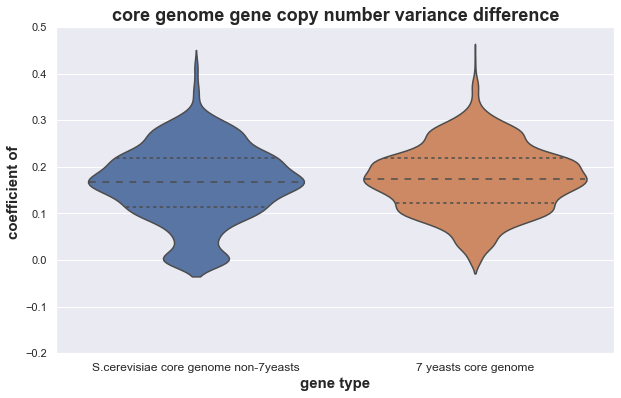

In [167]:
import scipy.stats as stats
# compare the gene copy number variance difference between sce core genome and 7 yeasts core genome
plt.figure(figsize=(10,6))
sns.set()
plt.title('core genome gene copy number variance difference',fontsize=18,fontweight='bold')
yeasts_core_cvlist=sce1800_core_cnv_info[sce1800_core_cnv_info.index.isin(yeasts_coreList)]["cv"].tolist()
sce_core_nonyeasts_cvlist=sce1800_core_cnv_info[~sce1800_core_cnv_info.index.isin(yeasts_coreList)]["cv"].tolist()
sns.violinplot(data=[sce_core_nonyeasts_cvlist,yeasts_core_cvlist],inner='quartile')
# check wheather has significant difference between sce core genome and 7 yeasts core genome in cv
t,p=stats.ttest_ind(sce_core_nonyeasts_cvlist,yeasts_core_cvlist)
print("p value of S.cerevisiae core genome non-yeasts and yeasts core genome copy number variance distribution is {}".format(p))
plt.xticks([0,1],['S.cerevisiae core genome non-yeasts','yeasts core genome'],fontsize=12)
plt.xlabel('gene type',fontsize=15,fontweight='bold')
plt.ylabel('coefficient of ',fontsize=15,fontweight='bold')
plt.ylim(-0.2,0.5)
plt.show()

- conclusion:
1. yeasts core genes 在酿酒酵母中的基因拷贝数变异程度更大。该结果和酿酒酵母core vs accessory结果类似，可提出假说：存在性上约保守的基因，其拷贝数变化程度反倒更大，
2. yeasts core genes和 non-yeasts7core 基因在酿酒酵母中的平均拷贝数没有显著性差异。


In [81]:
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# umap clustering according to fluxome data
def umap_cluster(raw_data,emetric="euclidean",n_neighbors=15,min_dist=0.1,n_components=2):
    data = raw_data.iloc[:,:-1]
    data = pd.DataFrame(data, index=raw_data.index, columns=raw_data.columns[:-1])
    #UMAP降维
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=emetric)
    embedding = reducer.fit_transform(data)
    embedding = pd.DataFrame(embedding, index=raw_data.index, columns=["UMAP1", "UMAP2"])
    embedding["label"]=raw_data["label"]
    return embedding

def pca_analysis(cnvMatrix):
    data=cnvMatrix.iloc[:,:-1]
    # standardize the data
    data_std = StandardScaler().fit_transform(data)
    # PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data_std)
    df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    df_pca["label"]=cnvMatrix["label"].tolist()
    return df_pca

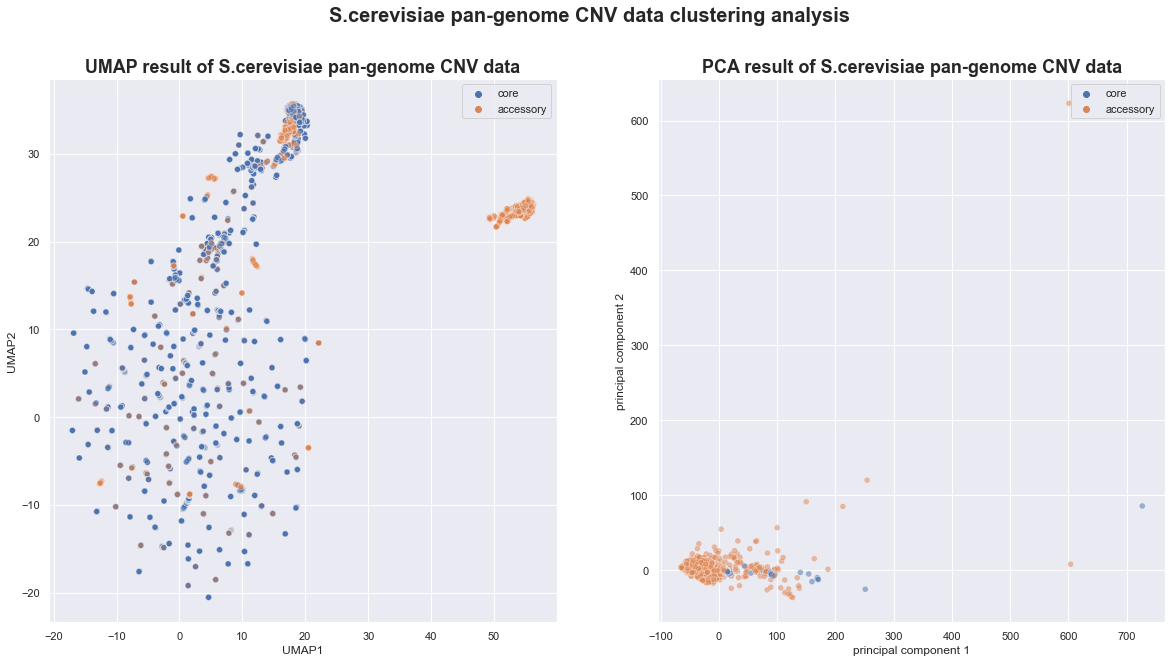

In [90]:
# clustering analysis of S.cerevisaie core genome and accessory genome based on copy number data
# label the core genome and accessory genome
sce1800_cnvMatrix.loc[sce1800_core99,'label']='core'
sce1800_cnvMatrix.loc[~df_sce_cnv_info.index.isin(sce1800_core99),'label']='accessory'

df_sce_umap_result=umap_cluster(sce1800_cnvMatrix,emetric="euclidean",n_neighbors=15,min_dist=0.2,n_components=2)
df_sce_pca_result=pca_analysis(sce1800_cnvMatrix)

# plot the umap and pca result
fig,ax=plt.subplots(1,2,figsize=(20,10))
sns.set()
sns.scatterplot(x="UMAP1",y="UMAP2",hue="label",data=df_sce_umap_result,ax=ax[0],alpha=0.5)
ax[0].set_title("UMAP result of S.cerevisiae pan-genome CNV data",fontsize=18,fontweight='bold')
ax[0].legend()

sns.scatterplot(x="principal component 1",y="principal component 2",hue="label",data=df_sce_pca_result,ax=ax[1],alpha=0.5)
ax[1].set_title("PCA result of S.cerevisiae pan-genome CNV data",fontsize=18,fontweight='bold')
ax[1].legend()

fig.suptitle("S.cerevisiae pan-genome CNV data clustering analysis",fontsize=20,fontweight='bold')
plt.show()

- According to PCA analysis, core genome can't be distinguish by PCA, however , it can be observed that core genome shows gathered in some cluster
- UMAP did not show distinct difference between core genome and accessory genome

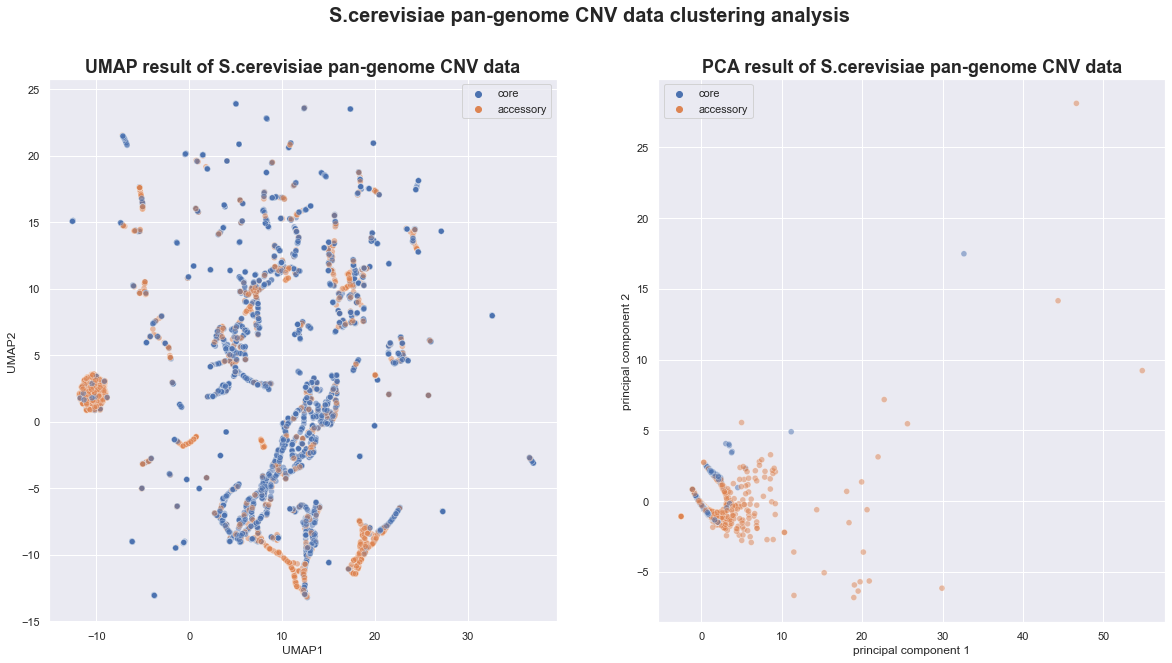

In [91]:
# clustering analysis of S.cerevisaie core genome and accessory genome based on copy number data
# label the core genome and accessory genome
df_sce_cnv_info.loc[sce1800_core99,'label']='core'
df_sce_cnv_info.loc[~df_sce_cnv_info.index.isin(sce1800_core99),'label']='accessory'

df_sce_umap_result=umap_cluster(df_sce_cnv_info,emetric="euclidean",n_neighbors=15,min_dist=0.2,n_components=2)
df_sce_pca_result=pca_analysis(df_sce_cnv_info)

# plot the umap and pca result
fig,ax=plt.subplots(1,2,figsize=(20,10))
sns.set()
sns.scatterplot(x="UMAP1",y="UMAP2",hue="label",data=df_sce_umap_result,ax=ax[0],alpha=0.5)
ax[0].set_title("UMAP result of S.cerevisiae pan-genome CNV data",fontsize=18,fontweight='bold')
ax[0].legend()

sns.scatterplot(x="principal component 1",y="principal component 2",hue="label",data=df_sce_pca_result,ax=ax[1],alpha=0.5)
ax[1].set_title("PCA result of S.cerevisiae pan-genome CNV data",fontsize=18,fontweight='bold')
ax[1].legend()

fig.suptitle("S.cerevisiae pan-genome CNV data clustering analysis",fontsize=20,fontweight='bold')
plt.show()
